In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import elevation
import elevation.prediction_pipeline as pp
import elevation.aggregation
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
np.random.seed(123) 
import scipy.stats as st
import pickle
#import seaborn
import matplotlib
import azimuth.util
import sklearn
import copy
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.linear_model
from sklearn.grid_search import GridSearchCV
import elevation.aggregation

In [19]:
# with open('\\\\nerds5\\compbio_storage\\CRISPR.offtarget\\gecko_new.calib1_ctnm1.3MM.v10.N9919088_groupby_nonagg_small.p', 'rb') as f:
with open('\\\\nerds5\\compbio_storage\\CRISPR.offtarget\\gecko_new.calib1_ctnm1.3MM.v10.N9919088_groupby_nonagg.p', 'rb') as f:
    results_gecko = pickle.load(f)# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko.calib0_countnormTrue.v7.gbrtw1.00e+02.N3137128_groupby_nonagg_small.p', 'rb') as f:

MAX_VALUE_JOHN = 1000
#with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko, 'rb') as f:
# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko_allmodels_calib0_countnormTrue.N3137128_groupby_nonagg.p', 'rb') as f:
#    results_gecko_v6 = pickle.load(f)

mit_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_complete.xls')
mit_gecko = mit_gecko[['offtarget_score', 'sgRNA measured value', 'sgRNA Sequence']].dropna()
st.spearmanr(mit_gecko['offtarget_score'], mit_gecko['sgRNA measured value'])
gecko_data = pd.read_csv('../../CRISPR/data/offtarget/3MM_michael/GeCKOv2_Non_essentials_Achilles_A375.txt', delimiter='\t')
gecko_data['full_seq'] = gecko_data['sgRNA context sequence'].apply(lambda x: x[4:20+4+3])
gecko_data['A375 Percent rank'] = gecko_data['sgRNA measured value']
gecko_merged = pd.merge(gecko_data, mit_gecko, left_on='sgRNA Sequence', right_on='sgRNA Sequence')

jd_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_updated.xls')
#jd_gecko['full_seq'] = jd['sgRNA Sequence'] + jd['PAM Sequence']
# jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average', 'full_seq']].set_index(['full_seq'])
# jd = jd.loc[jd['T1 MB12'] != 'MAX']
jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average']].replace([np.inf, -np.inf], MAX_VALUE_JOHN).dropna()
print gecko_merged.shape
print jd_gecko.shape
gecko_merged = pd.merge(gecko_merged, jd_gecko, on=['sgRNA Sequence'])
print gecko_merged.shape

(4695, 29)
(4039, 2)
(4039, 30)


In [26]:
MAX_VALUE_JOHN = 1000
#with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko, 'rb') as f:
# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko_allmodels_calib0_countnormTrue.N3137128_groupby_nonagg.p', 'rb') as f:
#    results_gecko_v6 = pickle.load(f)

mit_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_complete.xls')
mit_gecko = mit_gecko[['offtarget_score', 'sgRNA measured value', 'sgRNA Sequence']].dropna()
st.spearmanr(mit_gecko['offtarget_score'], mit_gecko['sgRNA measured value'])
gecko_data = pd.read_csv('../../CRISPR/data/offtarget/3MM_michael/GeCKOv2_Non_essentials_Achilles_A375.txt', delimiter='\t')
gecko_data['full_seq'] = gecko_data['sgRNA context sequence'].apply(lambda x: x[4:20+4+3])
gecko_data['A375 Percent rank'] = gecko_data['sgRNA measured value']
gecko_merged = pd.merge(gecko_data, mit_gecko, left_on='sgRNA Sequence', right_on='sgRNA Sequence')

jd_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_updated.xls')
#jd_gecko['full_seq'] = jd['sgRNA Sequence'] + jd['PAM Sequence']
# jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average', 'full_seq']].set_index(['full_seq'])
# jd = jd.loc[jd['T1 MB12'] != 'MAX']
jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average']].replace([np.inf, -np.inf], MAX_VALUE_JOHN).dropna()
print gecko_merged.shape
print jd_gecko.shape
gecko_merged = pd.merge(gecko_merged, jd_gecko, on=['sgRNA Sequence'])
print gecko_merged.shape

(4695, 29)
(4039, 2)
(4039, 30)


In [65]:
def aggregator_features(results, mit_results, N=None, methods=['product', 'CFD', 'linear-raw-stacker', 'MIT', 'ensemble', 'HsuZhang'], which='old'):
    truth = []
    broad = []
    mean = dict((m, []) for m in methods)
    score = dict((m, []) for m in methods)
    raw = dict((m, []) for m in methods)
    skipped = 0
    if N is None:
        N = min(len(results[1].keys()), mit_results.shape[0])
    
    D = 30
        
    features = dict((m, np.zeros((N, D))) for m in methods) # 46, 18
    features['ensemble'] = np.zeros((N, D*2))
    guides = []
    # pdf = np.exp(kd.score_samples(Xgs[:, None]))
    i = 0
    #for g in results[1].keys():
    for g in mit_results['full_seq'].values:

        if i % 1000 == 0:
            print i, mit_results['full_seq'].shape[0]

        try:
            for method in methods:
                if method == 'MIT':
                    mean[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                    score[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                elif method == 'broad':
                    score[method].append(-mit_results[mit_results['full_seq'] == g]['Broad_John_bin_average'].values[0])
                elif method == 'ensemble':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    features[method][i], names = elevation.aggregation.get_stats(np.array(results[0]['linear-raw-stacker'][g]), 
                                                                          np.array(results[0]['CFD'][g]), genic_g)
                elif method == 'HsuZhang':
                    t = np.array(results[0][method][g])
                    preds_g = t
                    score[method].append(100./(100 + np.sum(preds_g)))
                else:
                    t = np.array(results[0][method][g])
                    # if method == 'linear-raw-stacker':
                    #    a,b,c,d,f = [-0.40317539,  0.48128055,  0.6186926 ,  0.14710948,  0.78741327]

                    #    # avana = [ 1.26015589, -0.01607083,  4.17914254,  0.39207014, -0.30867801]
                    #    t =  a + b*t + c*np.tanh(d*t + f)
                    #    # print "WARNING: warping based on Avana values"
                    preds_g = t
                    genic_g = np.array(results[1][g]) != 'NoGene' 

                    mean[method].append(np.mean(preds_g[genic_g]))
                    score[method].append(np.sum(preds_g[genic_g])/float(len(preds_g)))


                    if which == 'old':
                        features[method][i] = elevation.aggregation.get_stats(preds_g, genic_g)
                    elif which == 'new':
                        features[method][i] = elevation.aggregation.get_stats(preds_g, genic_g)
                    else:
                        sorted_bo = np.sort(preds_g)
                        yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))
                        features[method][i] = yvals_bo[np.logspace(np.log10(2), np.log10(len(yvals_bo)), 50, dtype=int)-1]

                    raw[method].append((preds_g, genic_g))

                    # reference_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmin()].full_seq
                    # reference_offtargets = np.array(results[0][method][reference_guide])
                    # genic_reference = np.array(results[1][reference_guide]) != 'NoGene'
                    #bad_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmax()].full_seq
                    #bad_offtargets = np.array(results[0][method][bad_guide]
                    sorted_bo = np.sort(preds_g)
                    yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))

                    # try:
                    #    mean['KS2_%s'% method].append(st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1])
                    #    mean['AUC_%s' % method].append(sklearn.metrics.auc(sorted_bo, yvals_bo))
                    #except KeyError:
                    #    mean['KS2_%s'% method] = [st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1]]
                    #    mean['AUC_%s' % method] = [sklearn.metrics.auc(sorted_bo, yvals_bo)]

            i+=1
            truth.append(mit_results[mit_results['full_seq'] == g]['A375 Percent rank'].values[0])
            guides.append(g)

        except Exception as e:
            # print e
            # print "skipping guide: ", g
            skipped += 1
            #continue
            
    for method in mean.keys():
        mean[method] = np.array(mean[method])
        
    for method in score.keys():
        score[method] = np.array(score[method])
    print "skipped %d guides" % skipped
    return features, truth, mean, score,  guides


In [79]:
features_gecko, truth_gecko, mean_gecko, score_gecko,  guides_gecko = aggregator_features(results_gecko, gecko_merged, N=3890, 
                                                                           which='new',
                                                                                  methods=[ 
                                                                                         'MIT', 'ensemble', 'broad'])

for method in score_gecko:
    print method, features_gecko[method].shape, mean_gecko[method].shape, score_gecko[method].shape

0 4039
1000 4039
2000 4039
3000 4039
skipped 149 guides
broad (3890L, 30L) (0L,) (3890L,)
MIT (3890L, 30L) (4039L,) (4039L,)
ensemble (3890L, 60L) (0L,) (0L,)


In [80]:
y_rank = st.mstats.rankdata(truth_gecko)/float(len(truth_gecko))
kf = sklearn.cross_validation.KFold(y_rank.shape[0], n_folds=20, random_state=np.random.RandomState(1))
preds = dict((m, np.zeros_like(y_rank)) for m in features_gecko.keys())

for i, split in enumerate(kf):
    print i, len(train) + len(test)
    train, test = split
    for method in features_gecko.keys():

        if method == 'MIT' or method == 'broad':
            preds[method][test] = score_gecko[method][test]
        else:
            feat = features_gecko[method]
            final_model = elevation.aggregation.train_model(feat[train], y_rank[train])
            preds[method][test] = final_model.predict(feat[test])

0 3890
1 3890
2 3890
3 3890
4 3890
5 3890
6 3890
7 3890
8 3890
9 3890
10 3890
11 3890
12 3890
13 3890
14 3890
15 3890
16 3890
17 3890
18 3890
19 3890


In [85]:
with open("original_gecko_scores.pkl", "w") as fh:
    pickle.dump(score_gecko, fh)
with open("original_preds.pkl", "w") as fh:
    pickle.dump(preds, fh)

In [72]:
print list(preds['broad'])[-10:]
# print list(score_gecko['broad'])[-10:]
# print list(gecko_merged['Broad_John_bin_average'])[-100:]
# for i in list(gecko_merged['full_seq'].values)[-100:]:
#     print i

[-8.0, -21.0, -2.0, -3.0, -7.0, -6.0, -5.0, -8.0, -4.0, -0.0]


broad
MIT
ensemble


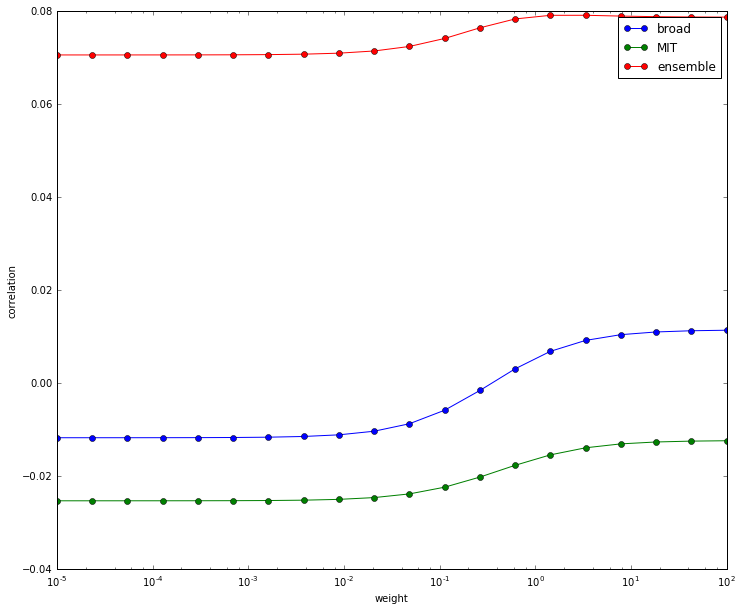

In [81]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')